# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: December 22, 2020

In [52]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
matplotlib.rcParams.update({'font.size': 22})

In [64]:
def CD_calc(Re, U=None, D=None, rho=None, mu=None):
    """
    Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
    reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf
    
    Use SI units
    
    """
    if Re is None:
        Re = rho*U*D/mu
    
    # Check to make sure Re value provided is consistent:
    if Re is not None:
        if U is not None:
            assert Re==rho*U*D/mu, "Provided Re is inconsistent with U, D, rho, and mu provided!"
            
    CD = (24/Re) \
    + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
    + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
    + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

    # Calculate FD if U and D and rho are given:
    if U is not None:
        FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
    else:
        FD = None
        
    return CD, FD

In [58]:
# Test CD Forward Solver:
Re_vec = np.geomspace(0.001, 1e7, 200)
CD_vec = []
for r in Re_vec:
    CD_vec.append(CD_calc(Re=r))

Text(0, 0.5, '$C_D$')

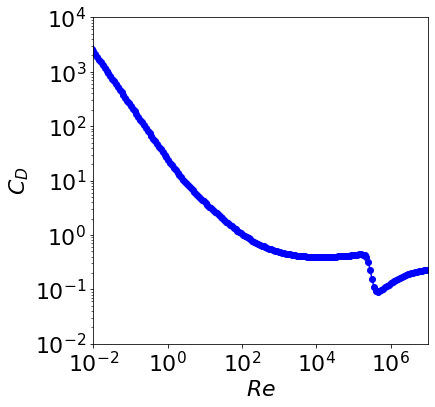

In [76]:
# Plot results from the forward solver:
plt.figure(figsize=(6,6))
plt.loglog(Re_vec, CD_vec, 'b-o')
plt.ylim(1e-2, 1e4)
plt.xlim(1e-2, 1e7)
plt.xlabel('$Re$')
plt.ylabel('$C_D$')

There are other ways to non-dimensionalize the $F_D$:  
$\Pi_1$ := $C_D$ = $\frac{F_D}{\rho.U^2.D^2}$ 

$\Pi_2$ = $\frac{F_D}{\mu.U.D}$  

$\Pi_3$ = $\frac{\rho.F_D}{\mu^2}$  

$\Pi_4$ = $\frac{F_D}{\mu.U}$

Assuming we can generate $F_D$ (i.e., experimentally), we want to explore the following:
* Plot the other $\Pi$ groups as a function for $Re$ to see how they look  
* If we were to randomly sample the main physical parameters (i.e., $\rho$, $U$, $\mu$, $D$), how efficiently and how well can we estimate $F_D$? The ground-truth is taken to be the experimental $C_D$ values fitted above.
* If instead, of the main physical parameters we use $Re$, $U$, $D$, and $\rho$ can we estimate $F_D$ more efficiently or better?
* How do I best visualize $F_D$ vs. $Re$? We expect the curve not to be as nice?

For all estimates, we will try first to use a deep fully connected network with some non-linearity.

Insight?: The non-dimensionalization helps with more efficient sampleing of the independent variable space? Uniformly sampling $Re$ more efficiently covers the space. 